# ModelingToolkit

# 6 Использование готовых библиотек

In [1]:
using ModelingToolkit, DifferentialEquations, IfElse, Plots

## 6.1 Стандартная библиотека ModelingToolkit

[Стандартная библиотека](https://docs.sciml.ai/ModelingToolkitStandardLibrary/stable/) содержит готовые компоненты для моделирования электрических и магнитных цепей, механические компоненты, тепловые компоненты и блоки для моделирования систем управления.

Рассмотрим пример моделирования регулируемого электропривода постоянного тока, приведенный в [документации](https://docs.sciml.ai/ModelingToolkitStandardLibrary/stable/tutorials/dc_motor_pi/)


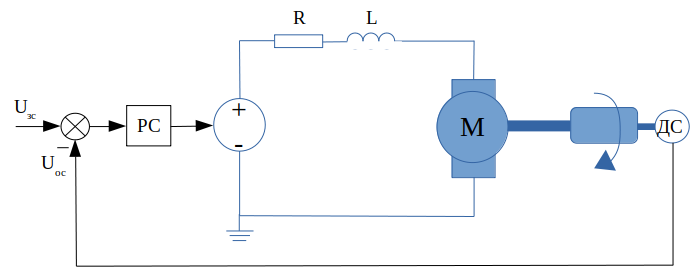

    ДС - датчик скорости
    РС - ПИ-регулятор скорости
    Uзс - сигнал задания скорости
    Uос - сигнал обратной связи по скорости

In [2]:
using ModelingToolkitStandardLibrary.Electrical
using ModelingToolkitStandardLibrary.Mechanical.Rotational
using ModelingToolkitStandardLibrary.Blocks

In [3]:
@variables t;

### Экземпляры компонентов

In [4]:
# электрические компоненты
@named source = Voltage()
@named R1 = Resistor(R = 0.5)
@named L1 = Inductor(L = 4.5e-3)
@named emf = EMF(k = 0.5)
@named ground = Ground()

# меxанические компоненты
@named load = Torque(use_support = false)
@named inertia = Inertia(J = 0.02)
@named friction = Damper(d = 0.01)
@named speed_sensor = SpeedSensor()
@named fixed = Fixed()

# компоненты цепи управления
@named feedback = Blocks.Feedback()
@named pi_controller = Blocks.LimPI(k = 1.1, T = 0.035, u_max = 10, Ta = 0.035)

# задающие компоненты
@named ref = Blocks.Step(height = 1, start_time = 0) # включение при t=0
@named load_step = Blocks.Step(height = -0.3, start_time = 1); # скачек нагрузки при t=1


### Сборка модели системы

In [5]:
connections = [connect(fixed.flange, emf.support, friction.flange_b)
               connect(emf.flange, friction.flange_a, inertia.flange_a)
               connect(inertia.flange_b, load.flange)
               connect(inertia.flange_b, speed_sensor.flange)
               connect(load_step.output, load.tau)
               connect(ref.output, feedback.input1)
               connect(speed_sensor.w, feedback.input2)
               connect(feedback.output, pi_controller.err_input)
               connect(pi_controller.ctr_output, source.V)
               connect(source.p, R1.p)
               connect(R1.n, L1.p)
               connect(L1.n, emf.p)
               connect(emf.n, source.n, ground.g)
]

@named model = ODESystem(connections, t,
    systems = [ground, ref, pi_controller, feedback, source, R1, L1, emf,
             fixed, load, load_step, inertia, friction, speed_sensor])

sys = structural_simplify(model);

### Симуляция

In [6]:
prob = ODEProblem(sys, [], (0, 2.0), [pi_controller.gainPI.k=>1.9])
sol = solve(prob, Rodas4());

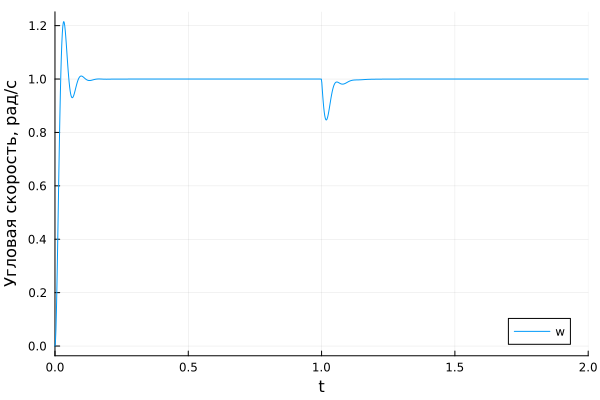

In [7]:
plot(sol, idxs=inertia.w, ylabel="Угловая скорость, рад/с", label="w")

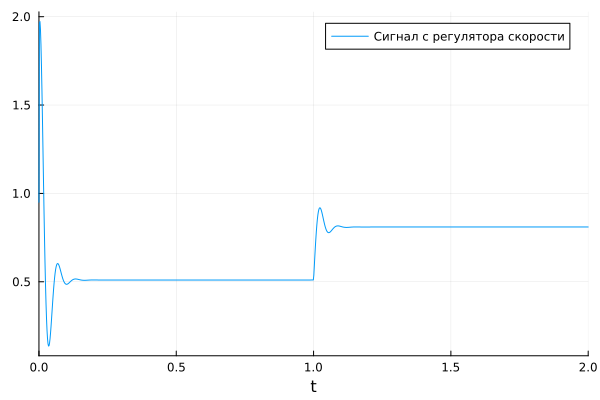

In [8]:
plot(sol, idxs=pi_controller.ctr_output.u, label="Сигнал с регулятора скорости")

In [9]:
?LimPI

search: LimPI LimPID structural_simplify ImplicitMidpoint portfoliocomposition



```
LimPI(;name, k=1, T, u_max=1, u_min=-u_max, Ta)
```

Text-book version of a PI-controller with actuator saturation and anti-windup measure.

# Parameters:

  * `k`: Gain
  * `T`: [s] Integrator time constant (T>0 required)
  * `Ta`: [s] Tracking time constant (Ta>0 required)
  * `x_start`: Initial value for the integrator

# Connectors:

  * `err_input`
  * `ctr_output`


## 6.2 Библиотека моделирования электромеханических переходных процессов в ЭЭС 

[Библиотека](https://www.researchgate.net/publication/362207975_DEVELOPMENT_OF_POWER_SYSTEM_SIMULATION_MODELS_USING_ACAUSAL_MODELING_LANGUAGES?_sg%5B0%5D=5aIB6rlQGUKWXpUNcLv-SIyznIyyjkjcwrrU6oUtMLSyCVER2Ew51ipR0cuxe--JDceF07VCd1eVA7fcRgiaSV7wUBhvZ21v2oaJ2lok.HD8UwwEfdtOkWzVKVmKPgEmvvL_eQBGW5bo5qvdJDN6I62tF94lZ60Xfq_kkkw0oGwLYhyTRcj936eAva7dTHA) включает готовые компоненты для моделирования линии электропередачи, трасформатора, синхронных машин различного порядка, нагрузки, динамические звенья для создания систем регулирования генераторов (регуляторы возбуждения, скорости, стабилизаторы) и др.

Рассмотрим простую систему с одним генератором, работающим на шины бесконечной мощности:

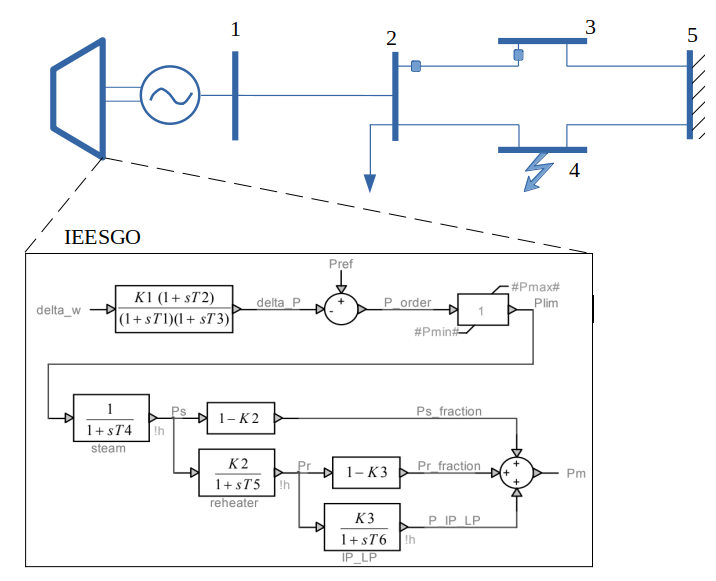

Смоделируем переходный процесс, возникающий при коротком замыкании в узле 4 и коммутации линии 2-3 

### Экземпляры компонентов системы 



In [ ]:
using Dynaps

In [11]:
# Шины бесконечной мощности
@named slack = Dynaps.Machines.GENCLS(
        Ra=0.0,
        Xd=0.2,
        D=0,
        H=0,
        SRated=100,
        Sbase=100,
        freq=50,
        V_init=1.00081,
        θ_init=0,
        P_init=-29.9864617775085,
        Q_init=-2.19613317360885
    )
# Генератор GENROU
@named gen = Dynaps.Machines.GENROU(
        Ra=0.0,
        Xd=1.84,
        Xq=1.75,
        X1d=0.41,
        X1q=0.6,
        X2d=0.2,
        X2q=0.2,
        Xl=0.12,
        T1d0=5.0,
        T1q0=0.9,
        T2d0=0.07,
        T2q0=0.09,
        D=0,
        H=4.28,
        SRated=100,
        Sbase=100,
        freq=50,
        V_init=1.01184,
        θ_init=deg2rad(5.094704777949743),
        P_init=40,
        Q_init=9.903777684558253,
    )
# Сеть
@named line_1_2 = Dynaps.Branches.Branch(
        R=0.001, 
        X=0.2,
        G=0.0,
        B=0.0
    )
@named line_2_3 = Dynaps.Branches.Branch(
        R=0.0005, 
        X=0.1, 
        G=0.0,
        B=0.0,
        breakers="From&To", 
        breakers_status_init=1, 
        T_switch=[10,15],
    )
@named line_2_4 = Dynaps.Branches.Branch(
        R=0.0005, 
        X=0.1,
        G=0.0,
        B=0.0
    )
@named line_3_5 = Dynaps.Branches.Branch(
        R=0.0005, 
        X=0.1,
        G=0.0,
        B=0.0,
    )
@named line_4_5 = Dynaps.Branches.Branch(
        R=0.0005, 
        X=0.1,
        G=0.0,
        B=0.0
    )
# Нагрузка
@named load = Dynaps.Loads.ZIPLoad(
        P_init=10/100, 
        Q_init=5/100, 
        V_init=1,
        a1=0,
        a2=1,
        b1=0,
        b2=1,
    )
# Шунт короткого замыкания
@named fault = Dynaps.Events.Fault(
        R=0.001, 
        X=0.001, 
        fault_time=2,
        duration=0.15,
    );
# Регулятор скорости вращения турбины
@named tg = Dynaps.Controls.TG.IEESGO(
        T1=0.01, 
        T2=0, 
        T3=0.15, 
        T4=0.3, 
        T5=8, 
        T6=0.4, 
        K1=20, 
        K2=0.7, 
        K3=0.43, 
        Pmax=1, 
        Pmin=0
    );

### Сборка модели системы

In [12]:
eqs = [
        connect(gen.p, line_1_2.p)               # узел 1
        connect(line_1_2.n, line_2_3.p, line_2_4.p, load.p) # узел 2
        connect(line_2_3.n, line_3_5.p)          # узел 3
        connect(line_2_4.n, line_4_5.p, fault.p) # узел 4
        connect(line_3_5.n, line_4_5.n, slack.p) # узел 5
        tg.Pmech ~ gen.Pm
        tg.Pm0 ~ gen.Pm0
        tg.Δω ~ gen.Δω
        gen.Vf ~ gen.Vf0     
]

@named ps = ODESystem(eqs, t, [], [], 
       systems = [line_1_2, line_2_3, line_2_4, line_3_5, line_4_5, 
        load, fault, gen, slack, tg])

sys = structural_simplify(ps);

In [13]:
prob = ODEProblem(sys, [], (0, 30), [gen.H=>2.5], jac=true);

### Инициализация 

Для инициализации найдем стационарный режим, решив систему уравнений, в которой производные приравнены нулю (динамика отсутствует)
\begin{equation*}
 \begin{cases}
   \frac{dy}{dt} = f(y,x,t), 
   \\
   0 = g(y,x,t),
  \end{cases}
  =>
 \begin{cases}
   0 = f(y,x,t), 
   \\
   0 = g(y,x,t),
  \end{cases}
\end{equation*}

Для решения системы нелинейных уравнений используем пакет [NonlinearSolve.jl](https://docs.sciml.ai/NonlinearSolve/stable/)

In [14]:
using NonlinearSolve

In [15]:
prob.u0 .= solve(NonlinearProblem(prob), NewtonRaphson()).u;

### Симуляция

In [16]:
sol = solve(prob, Rosenbrock23(), dense=false, 
    initializealg=NoInit(), abstol=1e-8, reltol=1e-8);

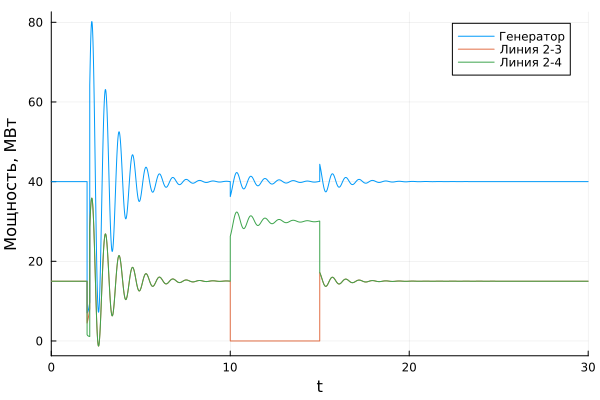

In [17]:
plot(sol, idxs=[gen.P, line_2_3.P_fr, line_2_4.P_fr], 
    ylabel="Мощность, МВт", label=["Генератор" "Линия 2-3" "Линия 2-4"])

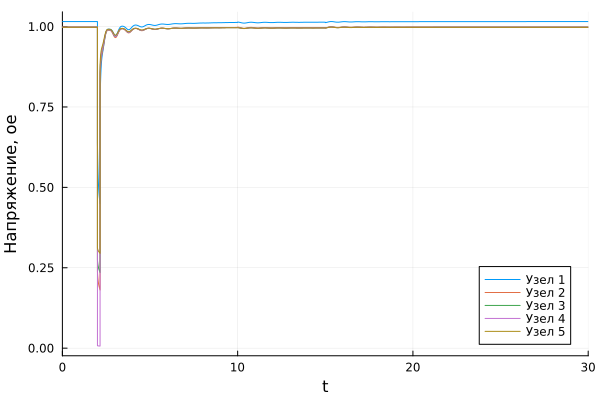

In [18]:
plot(sol, idxs=[
        gen.V, 
        load.V, 
        hypot(line_2_3.n.Vre, line_2_3.n.Vim), 
        hypot(line_2_4.n.Vre, line_2_4.n.Vim),
        slack.V,
        ],
    ylabel="Напряжение, ое", 
    label=["Узел 1" "Узел 2" "Узел 3" "Узел 4" "Узел 5"]
)

In [19]:
?Dynaps.Machines.GENROU

```
GENROU_SI(;name, Ra=0.0, Xd=0.25, Xq=0.2, X1d=0.1, X1q=0.1, X2d=0.1, X2q=0.1, Xl=0.12, T1d0=1, T1q0=0.5, T2d0=0.4, T2q0=0.3, D=0.0, H=0.0, SRated=100, VRated=400, Sbase=100, Vbase=100, freq=50, P_init=1.0, Q_init=1.0, V_init=1.0, θ_init=0.0, saturation=false, S10=1.0, S12=1.2)
```

Модель неявнополюсной синхронной машины GENROU.

# Параметры:

  * `Ra` ≥ 0 – активное сопротивление обмотки статора, oe;
  * `Xd` ≥ 0 – синхронное индуктивное сопротивление по продольной оси, oe;
  * `Xq` ≥ 0 – синхронное индуктивное сопротивление по поперечной оси, oe;
  * `X1d` – переходное сопротивление по продольной оси, oe;
  * `X1q` – переходное сопротивление по поперечной оси, oe;
  * `X2d` – сверхпереходное сопротивление по продольной оси, oe;
  * `X2q`=`X2d` – сверхпереходное сопротивление по поперечной оси, oe;
  * `Xl` – индуктивное сопротивление утечки, oe;
  * `T1d0` > 0 – переходная постоянная времени при разомкнутой обмотке статора по продольной оси, c;
  * `T1q0` > 0 – переходная постоянная времени при разомкнутой обмотке статора по поперечной оси, c;
  * `T2d0` > 0 – сверхпереходная постоянная времени при разомкнутой обмотке статора по продольной оси, c;
  * `T2q0` > 0 – сверхпереходная постоянная времени при разомкнутой обмотке статора по поперечной оси, c;
  * `D` ≥ 0 – коэффициент демпфирования;
  * `H` > 0 – постоянная инерции, c;
  * `SRated` – номинальная мощность машины, МВА;
  * `VRated` – номинальное напряжение, кВ;
  * `Sbase` – базисная мошность узла присоединения, МВА;
  * `Vbase` – базисное напряжение узла присоединения, кВ;
  * `freq` > 0 – частота, Гц;
  * `P_init` – активная мощность генерации в исходном режиме, МВт;
  * `Q_init` – реактивная мощность генерации в исходном режиме, МВАр;
  * `V_init` > 0 – напряжение на выводах в исходном режиме, кВ;
  * `θ_init` – угол напряжения, рад;
  * `saturation` – если true, учитывать насыщение;
  * `S10` – коэффициент насыщения при 1.0 о.е.;
  * `S12` – коэффициент насыщения при 1.2. о.е.

# Переменные:

  * `Δω` – отклонение угловой скорости от номинальной, SPEED, oe;
  * `δ` – угол ротора, ANGLE, рад;
  * `vd` – напряжение по d-оси, ое (относительно базиса машины);
  * `vq` – напряжение по q-оси, ое (относительно базиса машины);
  * `id` – ток по d-оси, ое (относительно базиса машины);
  * `iq` – ток по q-оси, ое (относительно базиса машины);
  * `P` – вырабатываемая активная мощность, МВт;
  * `Q` – вырабатываемая реактивная мощность, МВАр;
  * `V` – напряжение на выводах генератора, oe (относительно базиса сети);
  * `θ` – угол напряжения, рад;
  * `I` – величина тока генератора, oe (относительно базиса сети);
  * `ϕ` – угол тока, рад;
  * `Te` – электромагнитный момент, oe (относительно базиса машины);
  * `e1d` – переходная ЭДС по d-оси, oe (относительно базиса машины);
  * `e1q` – переходная ЭДС по q-оси, oe (относительно базиса машины);
  * `Ψkd` – сверхпереходное потокосцепление по d-оси, oe (относительно базиса машины);
  * `Ψkq` – сверхпереходное потокосцепление по q-оси, oe (относительно базиса машины);
  * `Ψd` – потокосцепление по d-оси, oe (относительно базиса машины);
  * `Ψq` – потокосцепление по q-оси, oe (относительно базиса машины);
  * `Ψad` – магнитный поток в воздушном зазоре по d-оси, oe (относительно базиса машины);
  * `Ψaq` – магнитный поток в воздушном зазоре по q-оси, oe (относительно базиса машины);
  * `Ψa` – магнитный поток в воздушном зазоре, oe (относительно базиса машины);
  * `XadIfd` – ток возбуждения в обмотке ротора по d-оси, oe (относительно базиса машины);
  * `XaqI1q` – ток реакции по q-оси, oe (относительно базиса машины);
  * `Pm` – механическая мощность, oe (относительно базиса машины);
  * `Vf` – напряжение возбуждения, oe (относительно базиса машины);
  * `Pm0` – инициализирующая выходная переменная, oe (относительно базиса машины);
  * `Vf0` – инициализирующая выходная переменная, oe (относительно базиса машины).

# Порты:

  * `p`::[`PhasorPort`](@ref) – порт электрического соединения.
